In [65]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path

from sklearn.model_selection import train_test_split

import tensorflow as tf

In [66]:
import matplotlib.pyplot as plt

In [67]:
import warnings
warnings.filterwarnings('ignore')

In [68]:
image_dir = Path('D:\data science\project\SIH\Fish_Dataset\Fish_Dataset')


In [69]:
# Get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.png'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

filepaths, labels

(0        D:\data science\project\SIH\Fish_Dataset\Fish_...
 1        D:\data science\project\SIH\Fish_Dataset\Fish_...
 2        D:\data science\project\SIH\Fish_Dataset\Fish_...
 3        D:\data science\project\SIH\Fish_Dataset\Fish_...
 4        D:\data science\project\SIH\Fish_Dataset\Fish_...
                                ...                        
 18085    D:\data science\project\SIH\Fish_Dataset\Fish_...
 18086    D:\data science\project\SIH\Fish_Dataset\Fish_...
 18087    D:\data science\project\SIH\Fish_Dataset\Fish_...
 18088    D:\data science\project\SIH\Fish_Dataset\Fish_...
 18089    D:\data science\project\SIH\Fish_Dataset\Fish_...
 Name: Filepath, Length: 18090, dtype: object,
 0         Arowana
 1         Arowana
 2         Arowana
 3         Arowana
 4         Arowana
            ...   
 18085    Trout GT
 18086    Trout GT
 18087    Trout GT
 18088    Trout GT
 18089    Trout GT
 Name: Label, Length: 18090, dtype: object)

In [11]:
# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)
image_df

,Filepath,Label
0,D:\data science\project\SIH\Fish_Dataset\Fish_...,Arowana
1,D:\data science\project\SIH\Fish_Dataset\Fish_...,Arowana
2,D:\data science\project\SIH\Fish_Dataset\Fish_...,Arowana
3,D:\data science\project\SIH\Fish_Dataset\Fish_...,Arowana
4,D:\data science\project\SIH\Fish_Dataset\Fish_...,Arowana
...,...,...
18085,D:\data science\project\SIH\Fish_Dataset\Fish_...,Trout GT
18086,D:\data science\project\SIH\Fish_Dataset\Fish_...,Trout GT
18087,D:\data science\project\SIH\Fish_Dataset\Fish_...,Trout GT
18088,D:\data science\project\SIH\Fish_Dataset\Fish_...,Trout GT


In [12]:
# Drop GT images
image_df['Label'] = image_df['Label'].apply(lambda x: np.NaN if x[-2:] == 'GT' else x)
image_df = image_df.dropna(axis=0)

In [13]:
# Sample 200 images from each class
samples = []

for category in image_df['Label'].unique():
    if category=='Arowana' or category=='Spanish_Dancer_Jellyfish':
        category_slice = image_df.query("Label == @category")
        samples.append(category_slice.sample(40, random_state=1))
    else:
        category_slice = image_df.query("Label == @category")
        samples.append(category_slice.sample(200, random_state=1))

image_df = pd.concat(samples, axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)

In [14]:
image_df

,Filepath,Label
0,D:\data science\project\SIH\Fish_Dataset\Fish_...,Shrimp
1,D:\data science\project\SIH\Fish_Dataset\Fish_...,Trout
2,D:\data science\project\SIH\Fish_Dataset\Fish_...,Red Sea Bream
3,D:\data science\project\SIH\Fish_Dataset\Fish_...,Red Mullet
4,D:\data science\project\SIH\Fish_Dataset\Fish_...,Black Sea Sprat
...,...,...
1875,D:\data science\project\SIH\Fish_Dataset\Fish_...,Red Sea Bream
1876,D:\data science\project\SIH\Fish_Dataset\Fish_...,Trout
1877,D:\data science\project\SIH\Fish_Dataset\Fish_...,Sea Bass
1878,D:\data science\project\SIH\Fish_Dataset\Fish_...,Black Sea Sprat


In [15]:
train_df, test_df = train_test_split(image_df, train_size=0.7, shuffle=True, random_state=1)

In [16]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [17]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 1053 validated image filenames belonging to 11 classes.
Found 263 validated image filenames belonging to 11 classes.
Found 564 validated image filenames belonging to 11 classes.


In [18]:
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

# training

In [19]:
inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(11, activation='softmax')(x)


model = tf.keras.Model(inputs=inputs, outputs=outputs)


model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [20]:
history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=100,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        )
    ]
)

Epoch 1/100
33/33 [==============================] - 57s 2s/step - loss: 0.8205 - accuracy: 0.7588 - val_loss: 0.2050 - val_accuracy: 0.9544
Epoch 2/100
33/33 [==============================] - 28s 848ms/step - loss: 0.0783 - accuracy: 0.9848 - val_loss: 0.1079 - val_accuracy: 0.9772
Epoch 3/100
33/33 [==============================] - 28s 847ms/step - loss: 0.0263 - accuracy: 0.9981 - val_loss: 0.0823 - val_accuracy: 0.9772
Epoch 4/100
33/33 [==============================] - 28s 843ms/step - loss: 0.0116 - accuracy: 1.0000 - val_loss: 0.0604 - val_accuracy: 0.9886
Epoch 5/100
33/33 [==============================] - 28s 845ms/step - loss: 0.0077 - accuracy: 1.0000 - val_loss: 0.0560 - val_accuracy: 0.9848
Epoch 6/100
33/33 [==============================] - 29s 884ms/step - loss: 0.0048 - accuracy: 1.0000 - val_loss: 0.0496 - val_accuracy: 0.9886
Epoch 7/100
33/33 [==============================] - 31s 867ms/step - loss: 0.0034 - accuracy: 1.0000 - val_loss: 0.0506 - val_accuracy: 0.

In [21]:
#our classification
classification = ['Arowana','Black Sea Sprat', 'Gilt-Head Bream', "Hourse Mackerel", 'Red Mullet', ' Red Sea Bream', 'Sea Bass', 'Shrimp','Spanish_Dancer_Jellyfish', 'Stripped Red Mullet', 'Trout']

In [22]:
from tensorflow.keras.models import load_model

In [23]:
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.02577
Test Accuracy: 99.29%


In [37]:
model.save('fishModel6.h5')
print('Saved')

savedModel = load_model("fishModel6.h5")
savedModel.summary()

Saved
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                       

In [25]:
results = savedModel.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.02577
Test Accuracy: 99.29%


In [72]:
import imageio as iio

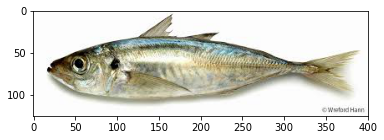

In [73]:
img = iio.imread('images.png')
img2 = plt.imshow(img)

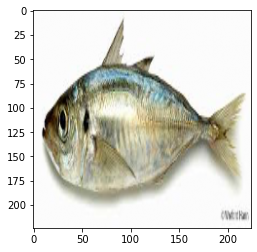

In [74]:
from skimage.transform import resize
resized_image = resize(img, (224,224,3));
img = plt.imshow(resized_image)

In [75]:
pred = savedModel.predict(np.array([resized_image]))
arr = pred[0]
x = np.where(arr == arr.max())

classification[x[0][0]], arr.max()

('Hourse Mackerel', 0.64365506)